In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import geopandas as gpd
import seaborn as sns
from thefuzz import fuzz
from thefuzz import process
import contextily as cx

# Extracting Senate and House Membership Lists

In [2]:
with open("house_list.txt", 'rt') as file:
    lines = file.readlines()

districts = [line.split(" ")[1] for line in lines]
names = [str.join(" ",line.split(" ")[5:]).split("(")[0].split("\t")[0].strip() for line in lines]
parties = []
towns = []
for line in lines:
    try:
        parties.append(line.split("(")[1].split(" ")[0])
        towns.append(line.split("-")[2].split(")")[0].strip())
    except:
        parties.append("Passamaquoddy Tribe")
        towns.append("Passamaquoddy Tribe")
representatives = pd.DataFrame.from_dict({"district": districts, "name": names, "party": parties, "town":towns})
representatives["title"] = "Rep"

with open("senate_list.txt", 'rt') as file:
    lines = file.readlines()

districts = [line.split(" ")[1] for line in lines]
names = [str.join(" ",line.split(" ")[4:]).split("(")[0].split("\t")[0].strip() for line in lines]
parties = [line.split("(")[1][0] for line in lines]
counties = [line.split("-")[2].split(")")[0].strip() for line in lines]

senators = pd.DataFrame.from_dict({"district": districts, "name": names, "party": parties, "county": counties})
senators["title"] = "Sen"

# Adding Geospatial Boundaries

In [3]:
senate_districts = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/MaineVotingDistricts2021StateSenate/FeatureServer/2/query?outFields=*&outSR=3857&where=1%3D1&f=geojson").set_index("ID")
house_districts = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/MaineVotingDistricts2021House/FeatureServer/0/query?outFields=*&outSR=3857&where=1%3D1&f=geojson").set_index("ID")

In [4]:
senators = senate_districts.merge(senators, how='outer', left_on="DISTRICT", right_on="district")
representatives = house_districts.merge(representatives, how="outer", left_on="DISTRICT", right_on="district")

In [5]:
members = pd.concat([representatives, senators]).reset_index(drop=True)
members["first"] = members["name"].apply(lambda x: x.split(" ")[0])
members["last"] = members["name"].apply(lambda x: x.split(" ")[-1])

Text(0.5, 0.98, 'Party Representation by District')

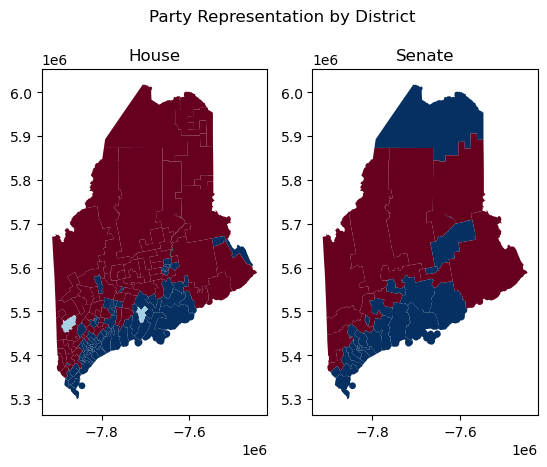

In [6]:
fig, axs = plt.subplots(1,2)
representatives.plot("party", ax=axs[0], cmap='RdBu_r')
axs[0].set_title("House")
senators.plot("party", ax=axs[1], cmap='RdBu_r')
axs[1].set_title("Senate")
fig.suptitle("Party Representation by District")

In [7]:
members.drop(columns="geometry").to_csv("member_list.csv")

# Extracting Committee Membership

In [8]:
def member_str_to_dict(member, committee):
    '''
    This function takes a string containing the name of the 
    committee member and other information and uses it to create 
    a dict that can then be used by pandas.
    '''
    # create the object with the committee name
    record = {"committee": committee}
    # split into two parts
    left, right = tuple(member.split(" ("))
    # extract the title (Sen or Rep) and the name from the left part
    record["title"], name = tuple(left.split(". ", maxsplit=1))
    # if the member has a second title (i.e. "Chair"), add that as a role
    if len(name.split(", ")) > 1:
        record["name"], record["role"] = tuple(name.split(", ", maxsplit=1))
    # also check if asterisk is present at the end
    elif right[-1] == '*':
        record["name"], record["role"] = name, "Ranking Minority Party Member"
        right = right[:-1]
    # otherwise, set role to None
    else:
        record["name"], record["role"] = name, None
    
    # split on hyphen to extract party and town
    if len(right[:-1].split("-", maxsplit=1)) == 2:
        record["party"], record["town"] = tuple(right[:-1].split("-", maxsplit=1))
    # catch the case where no party is listed (e.g. Passamaquoddy representative)
    else:
        record["party"], record["town"] = right[:-1], right[:-1]
    return record

In [9]:
# read the text file (copied from https://mainepolicy.org/committee-assignments-for-the-131st-legislature/)
with open("committee_list.txt", 'rt') as file:
    text = file.readlines()

# convert to a list of members
committee_members = []
committee_name = None
i = 1
while i < len(text):
    if text[i] == '\n': # indicates we are at the start of a new committee
        i += 1
        committee_name = text[i].strip()
    else:
        committee_members.append(member_str_to_dict(text[i].strip(), committee_name))
    i += 1

# turn it into a DataFrame
committee_members = pd.DataFrame.from_records(committee_members)
committee_members["first"] = committee_members["name"].apply(lambda x: x.split(" ")[0])
committee_members["last"] = committee_members["name"].apply(lambda x: x.split(" ")[-1])

# write dataframe to file
committee_members.to_csv("committee_list.csv")

In [10]:
committee_members

,committee,title,name,role,party,town,first,last
0,"Agriculture, Conservation and Forestry",Rep,William D. Pluecker,Chair,I,Warren,William,Pluecker
1,"Agriculture, Conservation and Forestry",Rep,Allison Hepler,None,D,Woolwich,Allison,Hepler
2,"Agriculture, Conservation and Forestry",Rep,Laurie Osher,None,D,Orono,Laurie,Osher
3,"Agriculture, Conservation and Forestry",Rep,Rebecca L. Jauch,None,D,Topsham,Rebecca,Jauch
4,"Agriculture, Conservation and Forestry",Rep,Kathleen A. Shaw,None,D,Auburn,Kathleen,Shaw
...,...,...,...,...,...,...,...,...
242,Joint Select Committee on Housing,Rep,Richard H. Campbell,None,R,Orrington,Richard,Campbell
243,Joint Select Committee on Housing,Rep,Mark John Blier,None,R,Buxton,Mark,Blier
244,Joint Select Committee on Housing,Sen,Teresa Pierce,Chair,D,Cumberland,Teresa,Pierce
245,Joint Select Committee on Housing,Sen,Eloise Vitelli,None,D,Sagadahoc,Eloise,Vitelli


# Committee Breakdowns

In [11]:
# How many members are on each committee?
committee_members.groupby("committee")["name"].count()

committee
Agriculture, Conservation and Forestry                        13
Appropriations and Financial Affairs                          13
Criminal Justice and Public Safety                            13
Education and Cultural Affairs                                13
Energy, Utilities and Technology                              13
Environment and Natural Resources                             13
Government Oversight Committee                                12
Health Coverage, Insurance and Financial Services             13
Health and Human Services                                     13
Inland Fisheries and Wildlife                                 13
Innovation, Development, Economic Advancement and Business    13
Joint Select Committee on Housing                             13
Judiciary                                                     14
Labor and Housing                                             13
Marine Resources                                              13
State and Local

Text(0, 0.5, 'Number of Members')

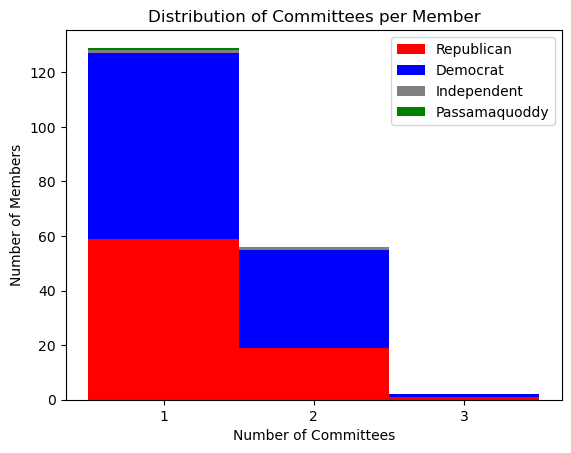

In [12]:
# How many committees is each member on?
committee_counts = committee_members.groupby(["party","name"]).count()["committee"]
plt.hist(
    [committee_counts['R'], committee_counts['D'], committee_counts['I'], committee_counts['Passamaquoddy Tribe']],
    range(1,5),
    stacked=True,
    color=['r', 'b','gray','g'],
    label=["Republican","Democrat", "Independent", "Passamaquoddy"],
    align='left'
    )
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.title("Distribution of Committees per Member")
plt.xlabel("Number of Committees")
plt.ylabel("Number of Members")

In [13]:
# How many from each party?
members.groupby("party").count()["name"].sort_values(ascending=False)

party
D                      104
R                       80
I                        2
Passamaquoddy Tribe      1
Name: name, dtype: int64

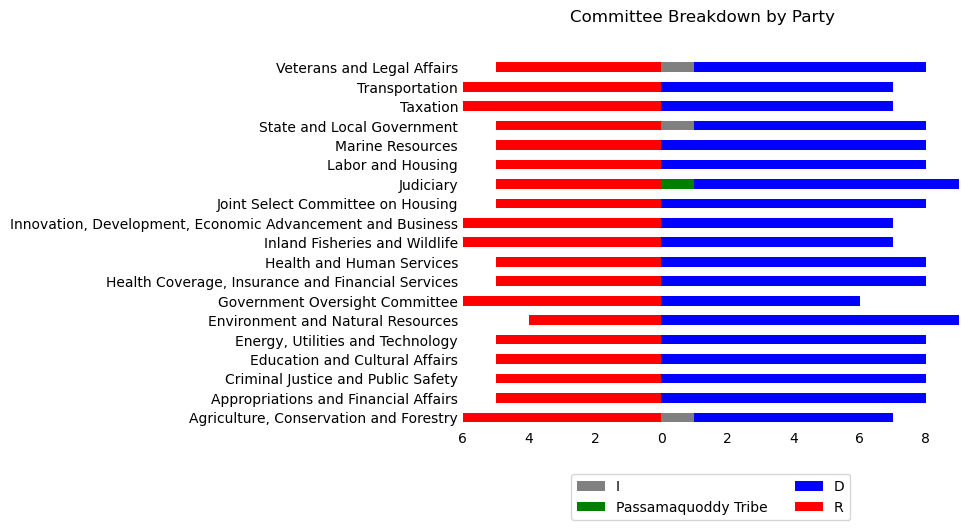

In [14]:
# partisanship by committee
fig, ax = plt.subplots()
fig.suptitle("Committee Breakdown by Party")

# count committee members by party
committee_counts = committee_members.groupby(["committee", "party"])["name"].count()
committee_counts.loc[:, "R"] = committee_counts.loc[:, "R"].values * -1

# reorder
plot_order = ["I", "Passamaquoddy Tribe", "D", "R"]
color_order = ["gray", "g", "b", "r"]

# plot bar charts, sorting by lean (second plot will follow the same sorting automatically)
committee_counts.unstack()[plot_order].plot(kind='barh', ax=ax, color=color_order, stacked=True).legend(bbox_to_anchor =(0.5,-0.27), loc='lower center', ncol=2)
ax.set_xlim(committee_counts.min(), committee_counts.max())
# scale and format both subplots
ax.set_ylabel("")
ax.set_frame_on(False)
ax.xaxis.set_major_formatter(lambda x, pos: str(int(abs(x))))
ax.tick_params(axis='both', which='both',length=0)


# Fuzzy Matching Member Names
Using `thefuzz` from SeatGeek https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

In [15]:
def match_member(member, matches):
    matched_name, score = process.extractOne(member, matches, scorer=fuzz.token_set_ratio)
    if score < 80:
        print("Double-check: {}\t{}".format(member, matched_name))
    return matched_name

In [16]:
committee_members["match_name"] = committee_members["name"].apply(lambda x: match_member(x, members["name"].to_list()))

Double-check: Tim Nangle	Timothy E. Nangle
Double-check: Ben Chipman	Benjamin M. Chipman
Double-check: Tim Nangle	Timothy E. Nangle


In [17]:
committee_members = gpd.GeoDataFrame(committee_members.merge(members[["name", "geometry"]], left_on="match_name", right_on="name", suffixes=(None,"_y")), crs='3857')

# Exploring the Geography of Committees

In [18]:
maine_boundary = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_State_Boundary_Polygon/FeatureServer/0/query?where=1=1&outSR=3857&f=geojson")

Text(0.5, 1.0, 'ACF Committee Member Districts')

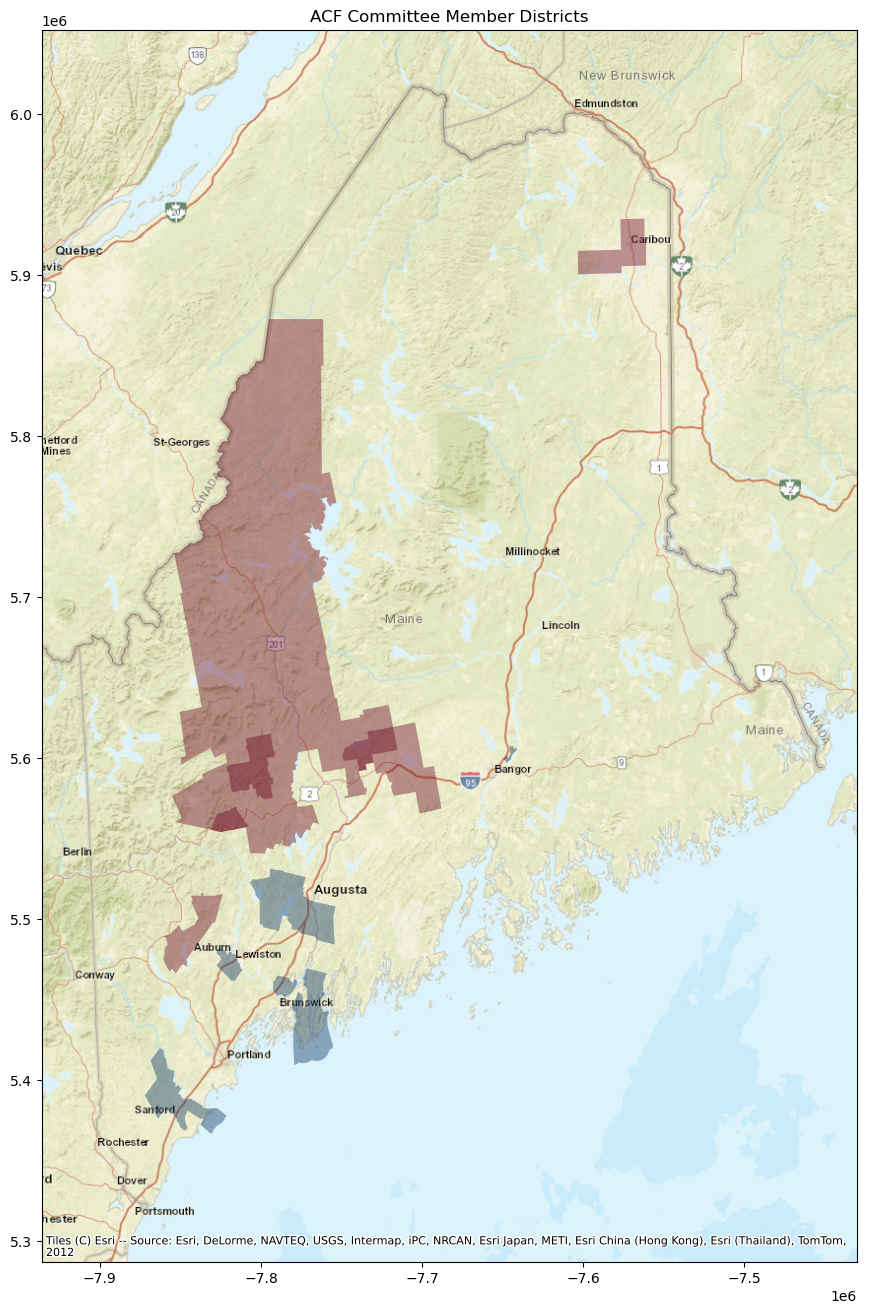

In [19]:
fig, ax = plt.subplots(figsize=(16,16))
maine_boundary.plot(ax=ax, edgecolor='k', alpha=0)
committee_members[committee_members["committee"] == "Agriculture, Conservation and Forestry"].plot("party", ax=ax, cmap='RdBu_r', alpha=0.4)
cx.add_basemap(ax, source=cx.providers.Esri.WorldStreetMap)
ax.set_title("ACF Committee Member Districts")